## Ames housing dataset submission - *Aimilios Chatzistamou*
---
### Goal of the Challenge 

###### We are looking to create an accurate model for real estate prices using Ames housing dataset.

Predicting housing prices is a classical problem in machine learning. We know that there is a high linearity: as the size and quality of the house increase, the sale price increases as well, so a linear model would be a decent solution. Given, however, the wide range of information available through the many features of the dataset, we can also imagine that there will be non-linearities we need to capture.

Thus, we will first use a neural network architecture to extract non-linearities automatically (which we would need to explicitly model using transformations (splines etc.) in linear regression), and subsequently compare it to the results we would get by using a strictly linear model.

The neural network is anticipated to more closely model the housing prices.

In [3]:
%matplotlib inline

from reader import get_housing_data
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
import random

In [2]:
#Getting the data
data = get_housing_data()
data.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
#First drop the columns that are obviously not correlated
data.columns
data = data.drop(['PID','Order'], axis=1)

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

There are continuous, but also categorical features, so we'll use dummy variables for the nominal variables.
<br>We'll also encode ordinal features that have `NA` such as bsmtcond in one-hot, since `NA` has to be a separate category.

In [5]:
nominal_columns=['MSSubClass', 'MSZoning','Street','Alley', 'LandContour', 'LotConfig',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation','Heating','CentralAir','GarageType','SaleType',
       'SaleCondition','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                'Electrical','FireplaceQu','GarageFinish','GarageQual','GarageCond',
                'PoolQC','Fence','MiscFeature']

data = pd.get_dummies(data, prefix=nominal_columns, columns=nominal_columns)

We then encode the ordinal features (one by one). <br>This is needed before checking for any correlations to sale price if we don't want to be making any assumptions.

In [7]:
cleanup_nums = {"LotShape":     {"Reg": 1, "IR1": 2, "IR2":3, "IR3":4},
                "Utilities": {"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0},
                "LandSlope": {"Gtl": 1, "Mod": 2, "Sev": 3},
                "ExterQual": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "ExterCond": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "HeatingQC": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "KitchenQual": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "Functional" : {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
                "PavedDrive" : {'Y':3,'P':2,'N':1}}

data.replace(cleanup_nums, inplace=True)
data = data.astype('float64')

For feature selection, we use pearson's correlation metric and choose `+-.2` threshold.
There are too many features for a scatter matrix visualisation.<br>We try to keep as much information as possible, but this can be adjusted later to train faster e.g.

In [32]:
corr = data.corrwith(data.SalePrice).sort_values()
threshold = .2
features = corr.index[abs(corr)>threshold].tolist()
features.remove('SalePrice')

We can nevertheless visualize a general correlation matrix for the variables most correlated to price (`.5` threshold)

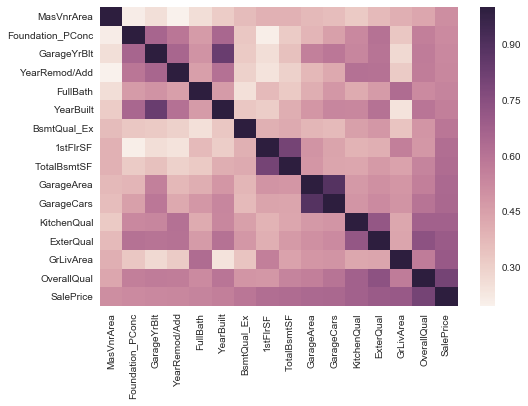

In [10]:
corr = data[corr.index[abs(corr)>0.5].tolist()].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The dataset has `nan` values which cannot be fed to the neural network. <br>
We impute the average value, as too much information would be lost if removed
(about `700/2900` rows have `nan`).

In [11]:
data = data.fillna(data.mean()).sort_index()

#normalise data
x = data[features].values #returns a numpy array
scaler = preprocessing.RobustScaler()
x_scaled = scaler.fit_transform(x)
data[features] = pd.DataFrame(x_scaled, columns=features)

#Split the data in train-dev-test
train, dev, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
train_X = train[features]
train_Y = train['SalePrice']
dev_X = dev[features]
dev_Y = dev['SalePrice'].values.reshape(dev.shape[0],1)
test_X = test[features]
test_Y = test['SalePrice'].values.reshape(test.shape[0],1)

After experimentation, settling on the following architecture:
- 3 layers deep network, with 40, 20 and 10 neurons for each layer
- RELU activation for hidden layers
- Batch gradient descent (no minibatches)
- Adam optimizer
- MEA (Mean Absolute Error) as cost function (instead of MSE, for more robustness to outliers)

In [12]:
run_name = 'last'
#Network parameters
n_hidden_1 = 40
n_hidden_2 = 20
n_hidden_3 = 10
num_input = len(features)

In [13]:
#Setting the hyperparameters
learning_rate = 0.001
n_epochs = 15000
display_step = 3000
batch_size = train_X.shape[0]
remain_prob = 0.999

In [14]:
#Tf Graph input
with tf.name_scope('input'):
    X = tf.placeholder("float", [None,num_input], name='X_input')
    Y = tf.placeholder("float", [None,1], name='Y_input')

with tf.name_scope('weights'):
    weights = {
        'W1': tf.get_variable('W1', [num_input, n_hidden_1],initializer=tf.contrib.layers.xavier_initializer()),
        'W2': tf.get_variable('W2',[n_hidden_1, n_hidden_2],initializer=tf.contrib.layers.xavier_initializer()),
        'W3': tf.get_variable('W3',[n_hidden_2, n_hidden_3],initializer=tf.contrib.layers.xavier_initializer()),
        'W_out': tf.get_variable('W_out',[n_hidden_3, 1])
    }
with tf.name_scope('biases'):
    biases = {
        'b1': tf.get_variable('b1',[n_hidden_1]),
        'b2': tf.get_variable('b2',[n_hidden_2]),
        'b3': tf.get_variable('b3',[n_hidden_3]),
        'b_out': tf.get_variable('b_out',[1])
    }

In [15]:
### Create model
def neural_net(x):
    layer_1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(x, weights['W1']), biases['b1'])),remain_prob)
    layer_2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_1, weights['W2']), biases['b2'])),remain_prob)
    layer_3 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_2, weights['W3']), biases['b3'])),remain_prob)
    out_layer = tf.matmul(layer_3, weights['W_out']) + biases['b_out']
    return out_layer

logits = neural_net(X)
with tf.name_scope('prediction'):
    prediction = logits

In [16]:
with tf.name_scope('Loss'):
    loss_op = tf.reduce_mean(tf.losses.absolute_difference(labels=Y,predictions=logits))
    mean_square_error = tf.reduce_mean(tf.squared_difference(logits, Y))
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()

tf.summary.scalar("cost", loss_op)
tf.summary.scalar("mean_square", mean_square_error)

summary_op = tf.summary.merge_all()

*Figure: Tensor graph used*

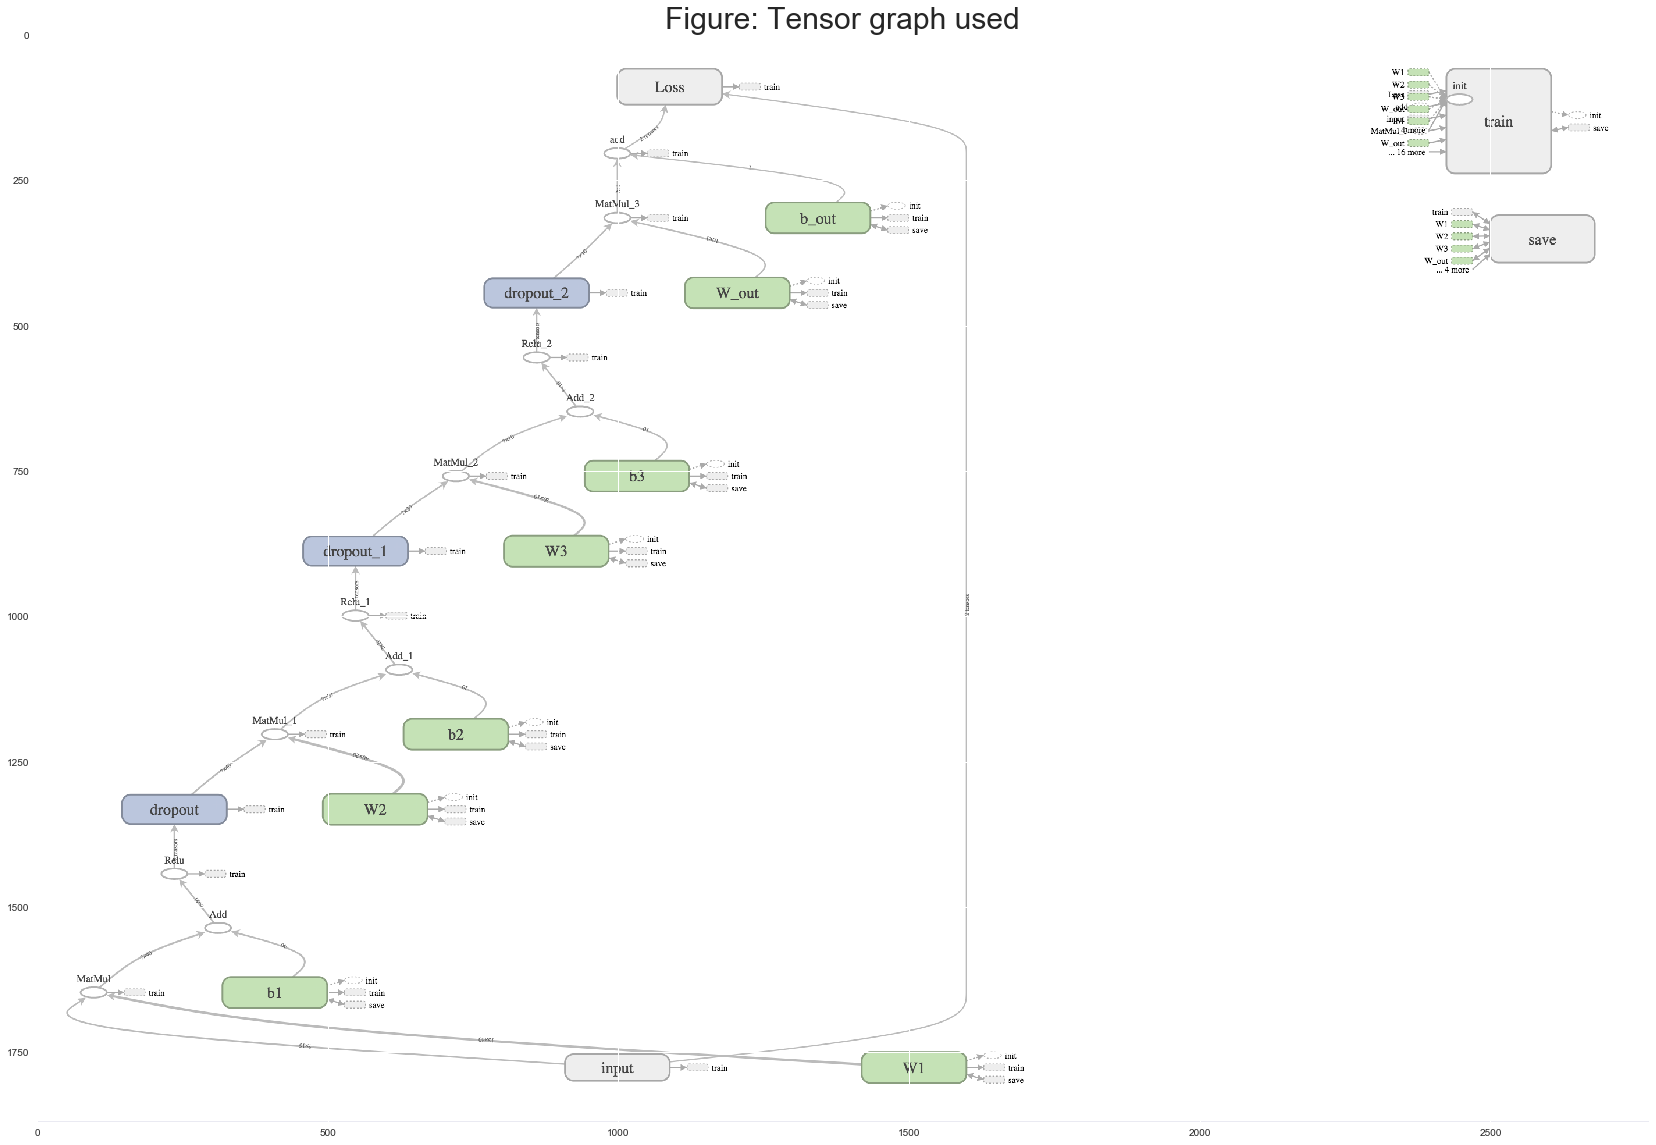

In [6]:
img=mpimg.imread('files/graph.png')
plt.figure(figsize=(30,20))
imgplot = plt.imshow(img)
plt.show()

In [17]:
#Added for minibatch experimentation
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

#Tensorboard saver        
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    file_writer = tf.summary.FileWriter('/tmp/tensorlogs/'+run_name, sess.graph)
    curves_writer = tf.summary.FileWriter('/tmp/tensorlogs/'+run_name+'curves', sess.graph)
    sess.run(init)
    step = 0
    for epoch in range(n_epochs):
        assert not np.any(np.isnan(train_X))
        for batch in iterate_minibatches(train_X, train_Y, batch_size):
            batch_x, batch_y = batch
            batch_y = batch_y.values.reshape(batch_size,1)
            step += 1
            
            # Run optimization op (backprop)
            _,loss_summary = sess.run([train_op, summary_op], feed_dict={X: batch_x, Y: batch_y})
            curves_summary = sess.run(summary_op, feed_dict={X: dev_X, Y: dev_Y})
            file_writer.add_summary(loss_summary, epoch * batch_size + step)
            curves_writer.add_summary(curves_summary, epoch * batch_size + step)
            
            if epoch % display_step == 0:
                # Calculate batch loss and accuracy
                tf.add_to_collection("prediction", prediction)
                loss = sess.run(loss_op, feed_dict={X: batch_x,Y: batch_y})
                saver.save(sess, "/tmp/model.ckpt", global_step=epoch, write_meta_graph=False)
                #print(sess.run([loss_op], feed_dict={X:dev_X,Y:dev_Y}))
                print("Epoch " + str(epoch) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss))


Epoch 0, Minibatch Loss= 181484.5938
Epoch 3000, Minibatch Loss= 20484.5020
Epoch 6000, Minibatch Loss= 15471.1387
Epoch 9000, Minibatch Loss= 12914.0801
Epoch 12000, Minibatch Loss= 11906.5986


In [18]:
#To make predictions after training, here does a random row prediction
row = random.randrange(train_Y.shape[0])
with tf.Session() as sess:
  # Restore variables from disk.
    #new_saver = tf.train.import_meta_graph('/tmp/model.ckpt-40000.meta')
    saver.restore(sess, tf.train.latest_checkpoint('/tmp/'))
    print("Model restored.")
    # Check the values of the variables
    print('actual: ',train_Y.iloc[row])
    print('prediction: ',sess.run(prediction, feed_dict={X:train_X.iloc[row].values.reshape(1,len(features))}))
    
    print('test error:', sess.run([loss_op,mean_square_error], feed_dict={X:test_X,Y:test_Y}))

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt-12000
Model restored.
actual:  115000.0
prediction:  [[ 117983.34375]]
test error: [15775.324, 5.7044102e+08]


Despite the slight overfit, the results were better without dropout regularisation.

**Stopped training very early (where train and dev set diverge) to avoid overfit**

*Figure: Learning curves for `.2` threshold*

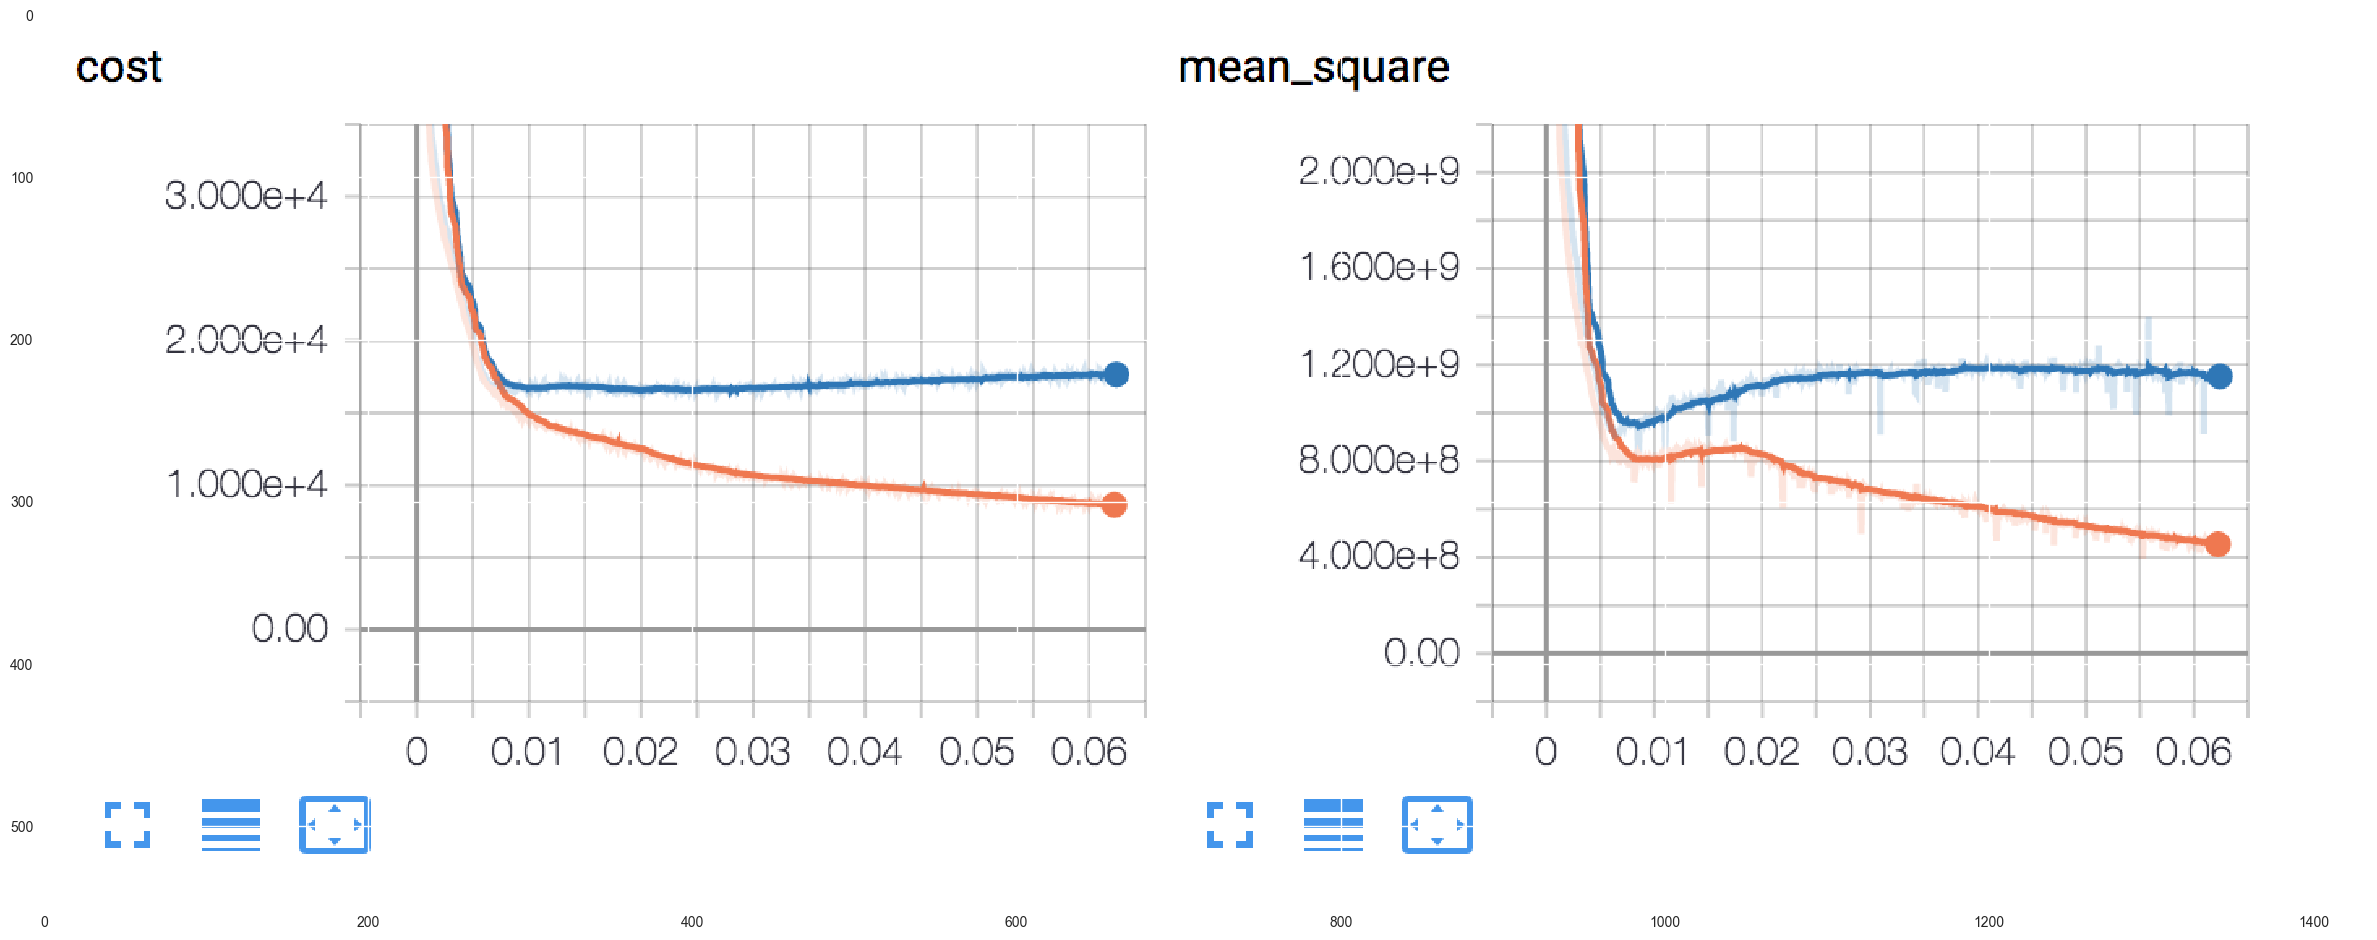

In [31]:
img=mpimg.imread('files/curves.png')
plt.figure(figsize=(30,20),dpi=100)
imgplot = plt.imshow(img)
plt.show()

*Results on Test Set after `10^6` epochs:*

| Threshold        | MAE           | MSE  |
|:-------------:|:-------------:|: -----:|
| `.2`      | `14854` | `4.6e+08` |            
| `.5`      | `17539`      |   `6.3e+08` |  

Note that the lower error for `.2` shows that keeping all the information was a good idea

*`MAS`: Mean Absolute Error* /
*`MSQ`: Mean Square Error*

#### We can then compare our model to a simple linear regression

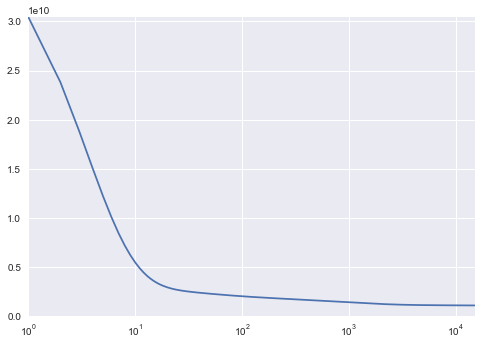

MSE: 824226496
MAE: 21004


In [19]:
learning_rate = 0.01
training_epochs = 15000
cost_history = np.empty(shape=[1],dtype=float)
n_dim = len(features)
x = tf.placeholder(tf.float32,[None,n_dim])
y = tf.placeholder(tf.float32,[None,1])
w = tf.Variable(tf.ones([n_dim,1]))
init = tf.global_variables_initializer()
y_ = tf.matmul(x, w)
cost = tf.reduce_mean(tf.square(y_ - y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

train_y = train_Y.append(pd.DataFrame(dev_Y))
train_x = pd.concat([train_X,dev_X])
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):
        sess.run(training_step,feed_dict={x:train_x,y:train_y})
        cost_history = np.append(cost_history,sess.run(cost,feed_dict={x:train_x,y:train_y}))

    plt.semilogx(range(len(cost_history)),cost_history)
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()

    mse = tf.reduce_mean(tf.square(y_ - test_Y))
    mae = tf.reduce_mean(tf.losses.absolute_difference(labels=test_Y,predictions=y_))
    print("MSE: %.0f" % sess.run(mse, feed_dict={x: test_X, y: test_Y})) 
    print("MAE: %.0f" % sess.run(mae, feed_dict={x: test_X, y: test_Y}))

We get an MSE of `1.5e+9`, which shows that a neural network can better capture the complexity of the pricing distribution. In terms of predictions, the neural network is more precise on the test set by about `7k`, with an average error of `15k` while linear regression has a `MAE` of `22k`.

*Here is a summary of the results:*

|Architecture| Threshold        | MAE           | MSE  |
|:----------:|:-------------:|:-------------:|: -----:|
|ANN         | .2      | 14854 | 4.6e+08 |        
|Linear      | .2      | 21837 | 1.5e+09 |       
|ANN         | .5      | 17539      |   6.3e+08 |      
|Linear      | .5      | 48682      |   4.8e+09 |

Note how the neural network is able learn much better from less features, with `.5` threshold it is almost `3` times more precise!